# 2. Preprocessing

In [238]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import scipy as sp
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from itertools import combinations_with_replacement

In [239]:
raw_data = pd.read_hdf('raw_data.h5', 'raw_data')

Let's shows few caracteristics of the data:

1. 5 first rows

In [240]:
raw_data.head()

,environment_identifier,signal_identifier,diffusion_coefficient,x,y,time,value,source_x,source_y
0,0,0,0.1,5.2,5.2,0.0,0.000000,5.0,5.0
1,0,0,0.1,5.2,5.2,0.1,0.001250,5.0,5.0
2,0,0,0.1,5.2,5.2,0.2,0.003500,5.0,5.0
3,0,0,0.1,5.2,5.2,0.3,0.006544,5.0,5.0
4,0,0,0.1,5.2,5.2,0.4,0.010211,5.0,5.0


2. Data description

In [241]:
raw_data.describe()

,environment_identifier,signal_identifier,diffusion_coefficient,x,y,time,value,source_x,source_y
count,6.664666e+06,6.664666e+06,6.664666e+06,6.664666e+06,6.664666e+06,6.664666e+06,6.664666e+06,6.664666e+06,6.664666e+06
mean,7.525525e+01,1.152400e+01,6.291242e-01,9.715117e+00,1.105255e+01,9.990000e+01,1.121877e-01,8.307588e+00,1.170591e+01
std,4.320760e+01,7.698807e+00,2.705623e-01,2.320712e+00,2.088750e+00,5.770616e+01,1.271239e-01,3.091138e+00,3.092209e+00
min,0.000000e+00,0.000000e+00,1.000000e-01,5.200000e+00,5.200000e+00,0.000000e+00,0.000000e+00,5.000000e+00,5.000000e+00
25%,3.700000e+01,5.000000e+00,4.000000e-01,8.000000e+00,9.800000e+00,4.990000e+01,2.081788e-02,5.000000e+00,1.000000e+01
50%,7.600000e+01,1.100000e+01,7.000000e-01,9.800000e+00,1.120000e+01,9.990000e+01,6.548511e-02,7.500000e+00,1.250000e+01
75%,1.130000e+02,1.700000e+01,9.000000e-01,1.140000e+01,1.260000e+01,1.499000e+02,1.598468e-01,1.000000e+01,1.500000e+01
max,1.490000e+02,3.300000e+01,1.000000e+00,1.560000e+01,1.560000e+01,1.998000e+02,6.063068e-01,1.500000e+01,1.500000e+01


3. Data general information

In [242]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6664666 entries, 0 to 6664665
Data columns (total 9 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   environment_identifier  int64  
 1   signal_identifier       int64  
 2   diffusion_coefficient   float64
 3   x                       float64
 4   y                       float64
 5   time                    float64
 6   value                   float64
 7   source_x                float64
 8   source_y                float64
dtypes: float64(7), int64(2)
memory usage: 508.5 MB


Create the new dataset with computed values.

In [243]:
grouped_signal_raw_data = raw_data.groupby(["environment_identifier", "signal_identifier"])

processed_data = grouped_signal_raw_data.agg({
    'value': ['sum',
                'mean',
                'std',
                'max',
                'median',
                sp.stats.kurtosis,
                sp.stats.skew],
    "x": "first",
    "y": "first",
    "source_x": "first",
    "source_y": "first",
    "diffusion_coefficient": "first"
}).reset_index()


processed_data.columns = ["environment_identifier", "signal_identifier", "value_sum", "value_mean", "value_std", "value_max", "value_median", "value_kurtosis", "value_skew", "x", "y", "source_x", "source_y", "diffusion_coefficient"]

# Compute the euclidean distance between the source and the sensor
processed_data["distance"] = np.linalg.norm(processed_data[["x", "y"]].values - processed_data[["source_x", "source_y"]].values, axis=1)

processed_data.head()

,environment_identifier,signal_identifier,value_sum,value_mean,value_std,value_max,value_median,value_kurtosis,value_skew,x,y,source_x,source_y,diffusion_coefficient,distance
0,0,0,773.448992,0.386918,0.103102,0.495555,0.426738,0.205065,-1.005637,5.2,5.2,5.0,5.0,0.1,0.282843
1,0,1,488.832414,0.244538,0.074971,0.330121,0.262778,1.358374,-1.262135,5.4,5.4,5.0,5.0,0.1,0.565685
2,0,2,329.556458,0.164861,0.063630,0.235276,0.183879,0.311865,-1.120173,5.6,5.6,5.0,5.0,0.1,0.848528
3,0,3,226.909896,0.113512,0.053599,0.172652,0.133476,-0.643591,-0.802090,5.8,5.8,5.0,5.0,0.1,1.131371
4,0,4,157.104661,0.078592,0.043755,0.129147,0.089494,-1.155635,-0.497455,6.0,6.0,5.0,5.0,0.1,1.414214


One information that could be useful is the time it takes for the gas to reach a certain distance. Since we have signals from multiple sensors, we can determine that by the relative offset between a reference signal and the other signals.

$$
\text{corr}(f, g)(k) = \sum_{i=1}^{N} f(i) \cdot g(i+k)
$$
where:
- $f$ and $g$ are two functions representing discrete signals
- $k$ is the relative offset between the two functions
- $N$ is the length of the signals

Since this kind of operation is very expensive, we will use the Fast Fourier Transform to calculate the correlation function.

$$
\text{corr}(f, g)(k) = \mathcal{F}^{-1}(\mathcal{F}(f) \cdot \mathcal{F}(g)^*)
$$
where:
- $f$ and $g$ are zero-padded to the same length
- $k$ is the relative offset between the two signals

The the maximum of the correlation function correspond to where the two signals are the most similar. This is the relative offset between the two signals.

$$
\text{relative offset} = \text{argmax}(\text{corr}(f, g)(k))
$$

In [244]:
def get_relative_shift_non_monotonic(signal_1, signal_2):
    """
    Get the relative offset between two signals using cross-correlation
    """

    # - Normalize the signals (necessary for monotonic signals)
    signal_1 = MinMaxScaler().fit_transform(signal_1.reshape(-1, 1)).flatten()
    signal_2 = MinMaxScaler().fit_transform(signal_2.reshape(-1, 1)).flatten()
   
    # Compute the fourier transform of the signals
    A = np.fft.fft(signal_1)
    B = np.fft.fft(signal_2)

    # Compute the cross-correlation
    cross_correlation = np.fft.ifft(A.conjugate() * B)

    #plt.plot(MinMaxScaler().fit_transform(np.abs(cross_correlation).reshape(-1, 1)).flatten(), label="Cross-correlation")
    #plt.plot(signal_1, label="Signal 1")
    #plt.plot(signal_2, label="Signal 2")
    #plt.legend()


    # Get the offset of the maximum value of the cross-correlation
    offset = np.argmax(np.abs(cross_correlation))

    #plt.title(f"Offset: {offset}")

    #plt.show()

    return offset

In [245]:
def get_relative_shift_monotonic(signal1, signal2):
    len1 = len(signal1)
    len2 = len(signal2)
    
    if len1 > len2:
        signal1, signal2 = signal2, signal1
        len1, len2 = len2, len1
    
    min_error = float('inf')
    best_shift = 0
    
    for shift in range(len2 - len1 + 1):
        error = np.sum((signal1 - signal2[shift:shift+len1])**2)
        if error < min_error:
            min_error = error
            best_shift = shift

    print(f"Best shift: {best_shift}")
            
    return best_shift

In [246]:
def get_relative_shifts(values):
    """
    Get the relative offsets between a list of signals
    where the first signal is the reference signal.
    The axis 0 of the signals array should be the sensors
    and the axis 1 should be the time.
    """

    pivoted_values = values.pivot(index="signal_identifier", columns="time", values="value")

    # We use the first signal as a reference but we could use any other signal
    reference_signal = pivoted_values.values[0]
    
    n, p = pivoted_values.values.shape

    results = pd.DataFrame({
        "signal_identifier": pivoted_values.index,
        "shift": np.zeros(n)
    })

    # Skip the reference signal since the offset is 0
    for index, row in pivoted_values.iterrows():
        results.loc[index, "shift"] = get_relative_shift_non_monotonic(reference_signal, row.values)


    return results

Compute the relative offset between the reference signal and the other signals.

In [247]:
grouped_environment_data = raw_data.groupby("environment_identifier").apply(get_relative_shifts, include_groups=False)

processed_data.drop(columns=["shift"], inplace=True, errors="ignore")

processed_data = processed_data.merge(grouped_environment_data, on=["environment_identifier", "signal_identifier"], how="left")

Plot first generated signals

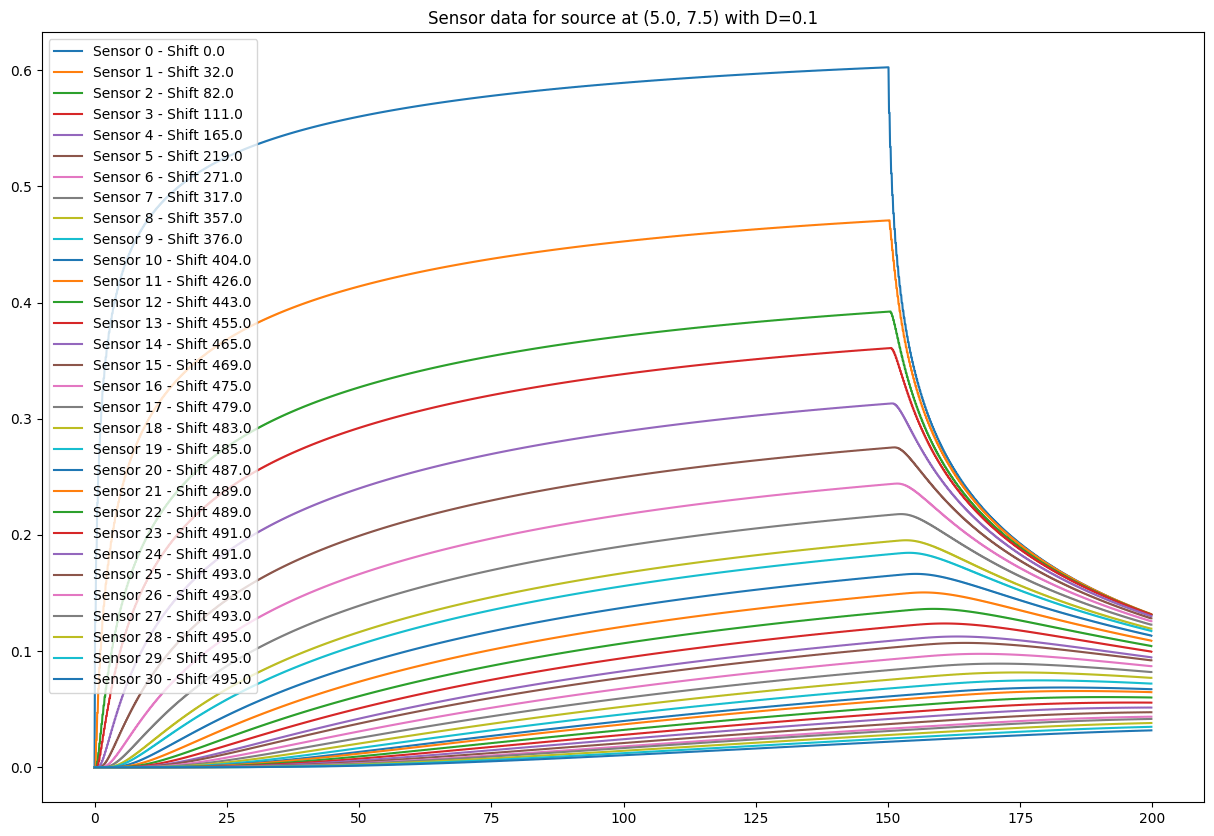

In [248]:
environment_index = 19

raw = raw_data[raw_data["environment_identifier"] == environment_index].pivot(index="signal_identifier", columns="time", values="value")

processed = processed_data[processed_data["environment_identifier"] == environment_index]

plt.figure(figsize=(15, 10))

for raw_index, p in zip(raw.index, processed["shift"]):
    plt.plot(raw.columns, raw.iloc[raw_index], label=f"Sensor {raw_index} - Shift {p}")

plt.title(f"Sensor data for source at ({processed['source_x'].values[0]}, {processed['source_y'].values[0]}) with D={raw_data['diffusion_coefficient'].values[0]}")
plt.legend()
plt.show()

Print the first 5 rows of the new dataset

In [249]:
processed_data.head()

,environment_identifier,signal_identifier,value_sum,value_mean,value_std,value_max,value_median,value_kurtosis,value_skew,x,y,source_x,source_y,diffusion_coefficient,distance,shift
0,0,0,773.448992,0.386918,0.103102,0.495555,0.426738,0.205065,-1.005637,5.2,5.2,5.0,5.0,0.1,0.282843,0.0
1,0,1,488.832414,0.244538,0.074971,0.330121,0.262778,1.358374,-1.262135,5.4,5.4,5.0,5.0,0.1,0.565685,130.0
2,0,2,329.556458,0.164861,0.063630,0.235276,0.183879,0.311865,-1.120173,5.6,5.6,5.0,5.0,0.1,0.848528,257.0
3,0,3,226.909896,0.113512,0.053599,0.172652,0.133476,-0.643591,-0.802090,5.8,5.8,5.0,5.0,0.1,1.131371,335.0
4,0,4,157.104661,0.078592,0.043755,0.129147,0.089494,-1.155635,-0.497455,6.0,6.0,5.0,5.0,0.1,1.414214,381.0


Save the new dataset

In [250]:
processed_data.to_hdf("processed_data.h5", key="processed_data", mode="w")